In [1]:
import os
import gc
import sys
import random

import torch
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb

In [2]:
ver_dir = Path('./model_20201209_lightgbm')
ver_dir.mkdir(exist_ok=True)

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(2020)

In [4]:
train_pickle = '../folds/cv1_train.pickle'
valid_pickle = '../folds/cv1_valid.pickle'
question_file = '../data/input/questions.csv'
debug = False
validaten_flg = False

In [5]:
def fast_left_merge(df1, df2, on):
    df2.index = df2[on]

    merged_df = pd.concat([
        df1.reset_index(drop=True),
        df2.reindex(df1[on].values).reset_index(drop=True).drop(on, axis=1)
    ], axis=1)
    
    return merged_df

In [6]:
# funcs for user stats with loop
def add_user_feats(df, answered_correctly_sum_u_dict, count_u_dict, prior_q_dict, attempt_cb_dict, answered_correctly_roll_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    pcf = np.zeros(len(df), dtype=np.int32)
    acb = np.zeros(len(df), dtype=np.int32)
    acr3 = np.zeros(len(df), dtype=np.float32)
    acr5 = np.zeros(len(df), dtype=np.float32)
    acr7 = np.zeros(len(df), dtype=np.float32)
    acr9 = np.zeros(len(df), dtype=np.float32)
    
    s = 1e-3
    
    default_array = np.zeros(9, dtype=np.int32)

    for cnt, row in enumerate(tqdm(df[['user_id', 'content_id', 'content_id_bin', 'answered_correctly']].values)):
        acsu[cnt] = answered_correctly_sum_u_dict.setdefault(row[0], 0)
        cu[cnt] = count_u_dict.setdefault(row[0], 0)
        if row[1] == prior_q_dict.setdefault(row[0], -1):
            pcf[cnt] = 1
        else:
            pcf[cnt] = 0
            
        acb[cnt] = attempt_cb_dict.setdefault(row[0], {}).setdefault(row[2], 1)
        
        acr = answered_correctly_roll_dict.setdefault(row[0], default_array)
        acr3 = np.mean(acr[:3])
        acr5 = np.mean(acr[:5])
        acr7 = np.mean(acr[:7])
        acr9[cnt] = np.mean(acr)

        answered_correctly_sum_u_dict[row[0]] += row[3]
        prior_q_dict[row[0]] = row[1]
        count_u_dict[row[0]] += 1
        attempt_cb_dict[row[0]][row[2]] += 1
        
        user_ac_roll = answered_correctly_roll_dict[row[0]]
        user_ac_roll = np.delete(user_ac_roll, 0)
        user_ac_roll = np.append(user_ac_roll, row[3])
        answered_correctly_roll_dict[row[0]] = user_ac_roll

    user_feats_df = pd.DataFrame({
        'answered_correctly_sum_u':acsu,
        'count_u':cu,
        'equal_prior_question_flag': pcf,
        'attempt_cb': acb,
        'answered_correctly_roll3': acr3,
        'answered_correctly_roll5': acr5,
        'answered_correctly_roll7': acr7,
        'answered_correctly_roll9': acr9
    })
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    user_feats_df['acr3_div_acr9'] = user_feats_df['answered_correctly_roll3'] / (user_feats_df['answered_correctly_roll9'] + s)
    user_feats_df['acr5_div_acr9'] = user_feats_df['answered_correctly_roll5'] / (user_feats_df['answered_correctly_roll9'] + s)
    user_feats_df['acr7_div_acr9'] = user_feats_df['answered_correctly_roll7'] / (user_feats_df['answered_correctly_roll9'] + s)
    user_feats_df['acr3_div_acr5'] = user_feats_df['answered_correctly_roll3'] / (user_feats_df['answered_correctly_roll5'] + s)
    user_feats_df['acr5_div_acr7'] = user_feats_df['answered_correctly_roll5'] / (user_feats_df['answered_correctly_roll7'] + s)
    user_feats_df['acr3_div_acr7'] = user_feats_df['answered_correctly_roll3'] / (user_feats_df['answered_correctly_roll7'] + s)
    df = pd.concat([df, user_feats_df], axis=1)
    return df

In [7]:
# read data
feld_needed = [
    'row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id', 'answered_correctly',
    'prior_question_elapsed_time', 'prior_question_had_explanation', 'task_container_id'
]
train = pd.read_pickle(train_pickle)[feld_needed]
valid = pd.read_pickle(valid_pickle)[feld_needed]
if debug:
    train = train[:1_000_000]
    valid = valid[:10_000]

In [8]:
user_count_df = train['user_id'].value_counts().reset_index()
user_count_df.columns = ['user_id', 'count_num']
user_count_df['count_bin'] = pd.cut(user_count_df['count_num'], 200, labels=False)

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=2020)

fold_df = pd.DataFrame(index=user_count_df.index)
for fold_, (trn_idx, val_idx) in enumerate(kfold.split(user_count_df, user_count_df['count_bin'])):
    fold_df[f'fold_{fold_}'] = 0
    fold_df.loc[val_idx, f'fold_{fold_}'] += 1

drop_train_users = user_count_df.loc[fold_df[fold_df['fold_0'] == 1].index, 'user_id'].values
train = train[~train['user_id'].isin(drop_train_users)].reset_index(drop=True)

/home/naoki/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


In [9]:
count_c_each_answer = pd.crosstab(index=train['content_id'],
                                                        columns=train['answered_correctly'])
count_c_each_answer.columns = ['lecture', 'ans_false', 'ans_true']
count_c_each_answer['rate_lecture'] = count_c_each_answer['lecture'] / count_c_each_answer.values.sum(axis=1)
c2rl = dict(count_c_each_answer['rate_lecture'])

train = train.loc[train.content_type_id == False].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)

whole = pd.concat([train[['content_id']], valid[['content_id']]], axis=0)
count_content_dict = whole['content_id'].value_counts()
train['count_c'] = train['content_id'].map(count_content_dict)
valid['count_c'] = valid['content_id'].map(count_content_dict)

del whole; gc.collect()


train['content_id_bin'] = train['content_id'] // 10
valid['content_id_bin'] = valid['content_id'] // 10



questions_df = pd.read_csv(question_file)[['question_id', 'part']]
q2p = dict(questions_df.values)

train['part'] = train['content_id'].map(q2p)
valid['part'] = valid['content_id'].map(q2p)

In [10]:
# user stats features with loops
answered_correctly_sum_u_dict = {}
count_u_dict = {}
prior_q_dict = {}
attempt_cb_dict = {}
answered_correctly_roll_dict = {}

train = add_user_feats(train, answered_correctly_sum_u_dict, count_u_dict, prior_q_dict, attempt_cb_dict, answered_correctly_roll_dict)
valid = add_user_feats(valid, answered_correctly_sum_u_dict, count_u_dict, prior_q_dict, attempt_cb_dict, answered_correctly_roll_dict)

# fill with mean value for prior_question_elapsed_time
# note that `train.prior_question_elapsed_time.mean()` dose not work!
# please refer https://www.kaggle.com/its7171/can-we-trust-pandas-mean for detail.
# prior_question_elapsed_time_mean = train.prior_question_elapsed_time.dropna().values.mean()
# train['prior_question_elapsed_time_mean'] = train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
# valid['prior_question_elapsed_time_mean'] = valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)

# use only last 30M training data for limited memory on kaggle env.
#train = train[-30000000:]

# changing dtype to avoid lightgbm error
train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')

In [11]:
import sys
from easydict import EasyDict as edict

sys.path.append('../src')
from factory import get_fold
from make_features.feature_utils import TargetEncoding

cfg = edict({
    'name': 'KFold',
    'params': {
        'n_splits': 5,
        'shuffle': True,
        'random_state': 0,
    },
    'split': {
        'y': 'user_id',
        'groups': None
    },
    'weight': 'average'
})


fold_df = get_fold(cfg, train)

col = 'content_id'
te = TargetEncoding(fold_df)
train[f'te_{col}_by_answered_correctly'] = te.fit_transform(train[col], train['answered_correctly'])
valid[f'te_{col}_by_answered_correctly'] = te.transform(valid[col])

In [12]:
TARGET = 'answered_correctly'
FEATS = [
    'answered_correctly_avg_u', 'answered_correctly_sum_u', 'count_u', 'equal_prior_question_flag',
    'te_content_id_by_answered_correctly', 'part', 'prior_question_had_explanation', 
    'prior_question_elapsed_time', 'attempt_cb', 'user_id', 'content_id_bin',
    'answered_correctly_roll3', 'answered_correctly_roll5', 'answered_correctly_roll7', 'answered_correctly_roll9',
    'acr3_div_acr9', 'acr5_div_acr9', 'acr7_div_acr9', 'acr3_div_acr5', 'acr5_div_acr7', 'acr3_div_acr7'
]

dro_cols = list(set(train.columns) - set(FEATS))
y_tr = train[TARGET]
y_va = valid[TARGET]
train.drop(dro_cols, axis=1, inplace=True)
valid.drop(dro_cols, axis=1, inplace=True)
_=gc.collect()

In [13]:
lgb_train = lgb.Dataset(train[FEATS], y_tr)
lgb_valid = lgb.Dataset(valid[FEATS], y_va)
del train, y_tr
_=gc.collect()

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.751623	valid_1's auc: 0.755906
[20]	training's auc: 0.754011	valid_1's auc: 0.758329
[30]	training's auc: 0.75486	valid_1's auc: 0.759154
[40]	training's auc: 0.755258	valid_1's auc: 0.759522
[50]	training's auc: 0.755506	valid_1's auc: 0.759736
[60]	training's auc: 0.755697	valid_1's auc: 0.759932
[70]	training's auc: 0.75589	valid_1's auc: 0.760154
[80]	training's auc: 0.756067	valid_1's auc: 0.760333
[90]	training's auc: 0.756201	valid_1's auc: 0.760463
[100]	training's auc: 0.756306	valid_1's auc: 0.76057
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.756306	valid_1's auc: 0.76057
auc: 0.7605700228406103


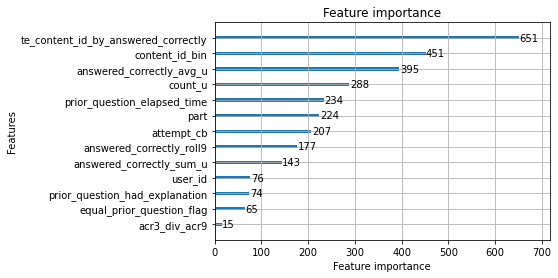

In [14]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.3,
#     'num_leaves': 32,
#     'min_child_samples': 20,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.3,
#     'bagging_freq': 1,
#     'bagging_seed': 11,
#     'max_bin': 255,
#     'verbose': -1,
#     'nthread': -1,
    'seed': 2020,
#     'first_metric_only': True
}

model = lgb.train(
                    lgb_params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=10,
                    num_boost_round=100,
                    early_stopping_rounds=10
                )
print('auc:', roc_auc_score(y_va, model.predict(valid[FEATS])))
_ = lgb.plot_importance(model)

In [15]:
import pickle

def save_pickle(obj, f_name):
    with open(f_name, 'wb') as f:
        pickle.dump(obj, f)

if debug:
    save_pickle(model, ver_dir / f'{str(ver_dir)}.pkl')
    save_pickle(answered_correctly_sum_u_dict, ver_dir / 'debug_answered_correctly_sum_u_dict.pkl')
    save_pickle(count_u_dict, ver_dir / 'debug_count_u_dict.pkl')
#     save_pickle(count_c_each_u_dict, 'debug_count_c_each_u_dict.pkl')
    save_pickle(prior_q_dict, ver_dir / 'debug_prior_q_dict.pkl')
    save_pickle(attempt_cb_dict, ver_dir / 'debug_attempt_cb_dict.pkl')
    save_pickle(te.encoder, ver_dir / 'debug_te_encoder.pkl')
    save_pickle(answered_correctly_roll_dict, ver_dir / 'debug_answered_correctly_roll_dict.pkl')
else:
    save_pickle(model, ver_dir / f'{str(ver_dir)}.pkl')
    save_pickle(answered_correctly_sum_u_dict, ver_dir / 'answered_correctly_sum_u_dict.pkl')
    save_pickle(count_u_dict, ver_dir / 'count_u_dict.pkl')
#     save_pickle(count_c_each_u_dict, 'count_c_each_u_dict.pkl')
    save_pickle(prior_q_dict, ver_dir / 'prior_q_dict.pkl')
    save_pickle(attempt_cb_dict, ver_dir / 'attempt_cb_dict.pkl')
    save_pickle(te.encoder, ver_dir / 'te_encoder.pkl')
    save_pickle(answered_correctly_roll_dict, ver_dir / 'answered_correctly_roll_dict.pkl')